# End-to-End API deployment

*As a dev, I want to focus on my business application.*

In this guide, we'll be using Domain name, ACME protocole, Kubernetes, OVH API and few other products such as Elastic Search index, NOSQL database and Gravitee.io.

# Kubernetes setup

[Setup](k8s.ipynb#Kubernetes-setup) your local environment, add nodes and configure Helm.

In [ ]:
. ./activate

# Install the IngressController

First thing first, we'll deploy a `LoadBalancer` and NGINX `IngressController` with `helm`.

You'll be using this [chart](https://github.com/helm/charts/tree/master/stable/nginx-ingress) and deploy it in the `kube-public` namespace.

In [ ]:
helm install stable/nginx-ingress --namespace kube-public --set controller.replicaCount=2

# Domain and certificates

## DNS config

Once the `IngressController` is up, you should get its ip and domain via `kubectl -n kube-public get svc -l component=controller`

In [ ]:
kubectl -n kube-public get svc -l component=controller

Using the above value, edit your DNS Zone accordingly via the OVH Manager

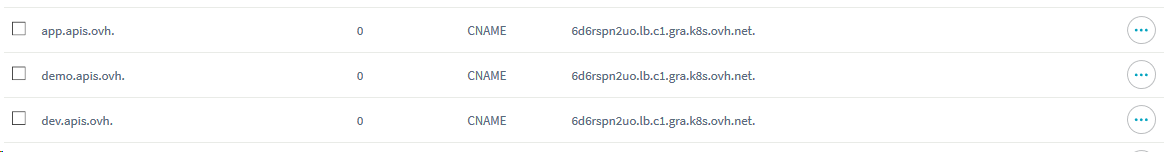


or via the OVH API

- with [`POST /domain/zone/{zoneName}/import`](https://api.ovh.com/console/#/domain/zone/%7BzoneName%7D/import#POST) to import the entire DNS zone
- with [`POST /domain/zone/{zoneName}/record`](https://api.ovh.com/console/#/domain/zone/%7BzoneName%7D/record#POST) to edit only entry.

**Tip**: To avoid waiting DNS config to propagate to your DNS servers - up to 24h -, set your DNS servers to OVH ones.

## Certificates

Once your DNS zone is up. You can generate TLS certificate follwing the ACME DNS protocole.

Unlike with HTTP protocol, you'll be able to generate certificate for wildcard sub-domain and without editing your web server configuration.

We strongly recommend to follow this [guide](https://github.com/Neilpang/acme.sh/wiki/How-to-use-OVH-domain-api#advanced-usage) which leverate OVH API and can be easilly automated.

After following the guide, you should generate the certificate with `acme.sh --issue --dns dns_ovh -d '*.apis.ovh'` from your local console.

You should obtain the following files: 

- `domain.key`: the domain private key
- `domain.csr`: the domain certificate signing request
- `domain.cer`: the domain public key
- `ca.cer`: the certificate authority public key
- `fullchain.cer`: the fullchain (CA + subordinate + your domain) public key

Let's create a `kubernetes.io/tls` secret


In [ ]:
kubectl create secret tls apis.ovh-cert --key ./domain.key --cert ./fullchain.cer

In [ ]:
kubectl describe secret apis.ovh-cert

# Install Gravitee.io

[gravitee.io](https://gravitee.io/) is an API manager. The setup is described [here](gravitee-setup.ipynb)


# Install Linkerd

The following commands are detailed [here](https://linkerd.io/2/getting-started/)


In [ ]:
linkerd check --pre && (linkerd install | kubectl apply -f -) # do a pre-check and install

In [ ]:
linkerd check # check installation went fine

You can open a tunnel to access Linkerd dashboard. Run the following command in a separate termminal
```
linkerd dashboard
```

Once linkerd is installed and configured, only an extra step is needed for the `Ingress`. In our case with NGINX, we have to follow this [documentation](https://linkerd.io/2/tasks/using-ingress/)

In [ ]:
kubectl get deploy -o yaml | linkerd inject - | kubectl apply -f - # to install Linkerd

In [ ]:
kubectl annotate ing gravitee-ui 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'
kubectl annotate ing gravitee-api 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'
kubectl annotate ing gravitee-gateway 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'

To remove the annotations

In [ ]:
kubectl annotate ing gravitee-ui nginx.ingress.kubernetes.io/upstream-vhost-
kubectl annotate ing gravitee-api nginx.ingress.kubernetes.io/upstream-vhost-
kubectl annotate ing gravitee-gateway nginx.ingress.kubernetes.io/upstream-vhost-